In [1]:
# Montar directorio de drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install unsloth
!pip install --force-reinstall --no-cache-dir --no-deps git+https://github.com/unslothai/unsloth.git


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 5.1 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.5/218.5 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.0/129.0 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.5/31.5 MB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.2/865.2 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/

  Cloning https://github.com/unslothai/unsloth.git to /tmp/pip-req-build-8779irwe
  Running command git clone --filter=blob:none --quiet https://github.com/unslothai/unsloth.git /tmp/pip-req-build-8779irwe
  Resolved https://github.com/unslothai/unsloth.git to commit b9067f98d124173b354808b116f931410e5b699c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for unsloth: filename=unsloth-2025.4.8-py3-none-any.whl size=263211 sha256=008af0d752b8855241c659d0c045a2c46ebafb8ef0e935786395ac1e26363af2
  Stored in directory: /tmp/pip-ephem-wheel-cache-jmevykry/wheels/d1/17/05/850ab10c33284a4763b0595cd8ea9d01fce6e221cac24b3c01
Successfully built unsloth
  Attempting uninstall: unsloth
    Found existing installation: unsloth 2025.4.7
    Uninstalling unsloth-2025.4.7:
      Successfully uninstalled unsloth-2025.4.7


In [3]:
!pip install python-dotenv

In [4]:
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('Hay %d GPU(s) disponibles.' % torch.cuda.device_count())
    print('Vamos a usar la GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No hay GPU disponible, usando CPU.')

Hay 1 GPU(s) disponibles.
Vamos a usar la GPU: Tesla T4


In [5]:
from unsloth import FastLanguageModel, is_bfloat16_supported
import torch
from trl import SFTTrainer

from huggingface_hub import login
from transformers import TrainingArguments, EarlyStoppingCallback, AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
import wandb
import pandas as pd
from datasets import Dataset
from dotenv import load_dotenv
import os
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, average_precision_score, accuracy_score, precision_recall_fscore_support, precision_score, recall_score

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [6]:
path = '/content/drive/Othercomputers/Mi PC/TFG/MySonGyny/MySonGyny-2025'
#path = '../'
#path = '/home/lobezno/Documentos'

In [ ]:
load_dotenv(f'{path}/cuadernos/.env')  # Carga las variables del .env

HUGGINGFACE_TOKEN = os.getenv("HUGGINGFACE_TOKEN")
WANDB_TOKEN = os.getenv("WANDB_TOKEN")

In [ ]:
hf_token = HUGGINGFACE_TOKEN
login(hf_token)

In [ ]:
wb_token = WANDB_TOKEN

wandb.login(key=wb_token)
run = wandb.init(
    project='Fine-tune-con-CoT-Tarea-2',
    job_type="training",
    anonymous="allow"
)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: atorojaen (atorojaen-university-of-huelva) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [7]:
COLUMN_ID = 'id'
COLUMN_LETRA = 'lyrics'
COLUMN_ETIQUETA = 'label'
COLUNM_ETIQUETALETRA = 'labelconletras'
COLUMN_RAZONAMIENTO = 'reasoning'
tipo_CoT = 'GPT4o'
model_name = 'DeepSeek-R1-Distill-Qwen-14B-unsloth-bnb-4bit'
csv_train_filepath = f'{path}/data/train_data/task2_GPT4o_dataReasoning.csv'
tipo_prompt = 0
#csv_test_filepath = f'{path}/data/train_data/testData.csv'

In [8]:
print(f"Cargando datos desde: {csv_train_filepath}")
try:
    # 1. Cargar el DataFrame separado
    df = pd.read_csv(csv_train_filepath, encoding='utf-8', encoding_errors="replace", sep=',')
    #test_df = pd.read_csv(csv_test_filepath, encoding='utf-8', encoding_errors="replace", sep=',')
    print(f"Columnas encontradas en el CSV: {df.columns.tolist()}")

    # 2. Dividir los datos
    print(f"Total de filas válidas antes de dividir: {len(df)}")
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df[COLUMN_ETIQUETA])
    train_df, valid_df = train_test_split(train_df, test_size=0.3, random_state=42, stratify=train_df[COLUMN_ETIQUETA])
    print(f"División completada:")
    print(f"  - Tamaño del conjunto de Entrenamiento: {len(train_df)}")
    print(f"  - Tamaño del conjunto de Validación:  {len(valid_df)}")
    print(f"  - Tamaño del conjunto de Test:         {len(test_df)}")

     # --- COMPROBACIÓN DE PROPORCIONES DE CLASE ---
    print("\n--- Distribución de Clases ---")
    print("Conjunto de Entrenamiento:")
    print(train_df[COLUNM_ETIQUETALETRA].value_counts(normalize=False)) # Conteos absolutos

    print("\nConjunto de Validación:")
    print(valid_df[COLUNM_ETIQUETALETRA].value_counts(normalize=False))

    print("\nConjunto de Test:")
    print(test_df[COLUNM_ETIQUETALETRA].value_counts(normalize=False))
    print("-----------------------------")

    nr_class_df = train_df[train_df[COLUMN_ETIQUETA] == 0]
    s_class_df = train_df[train_df[COLUMN_ETIQUETA] == 1]
    v_class_df = train_df[train_df[COLUMN_ETIQUETA] == 2]
    h_class_df = train_df[train_df[COLUMN_ETIQUETA] == 3]

    #----PARA HACER OVERSAMPLING---
    v_oversampled_df = resample(v_class_df,
                                       replace=True,     # Permitir duplicados
                                       n_samples=198,
                                       random_state=42)
    h_oversampled_df = resample(h_class_df,
                                       replace=True,     # Permitir duplicados
                                       n_samples=156,
                                       random_state=42)

    train_df_balanced = pd.concat([nr_class_df, s_class_df, v_oversampled_df, h_oversampled_df])

    #----PARA HACER UNDERSAMPLING---
    #majority_undersampled_df = resample(majority_class_df,
    #                                replace=False,  # Sin duplicados
    #                                n_samples=600,  # Mismo tamaño que minoritaria
    #                                random_state=42)

    #train_df_balanced = pd.concat([majority_undersampled_df, minority_oversampled_df])


    # Mezclar el DataFrame resultante para que las clases no estén agrupadas
    train_df_balanced = train_df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

    print("\nConjunto de Entrenamiento nuevo:")
    print(train_df_balanced[COLUNM_ETIQUETALETRA].value_counts(normalize=False))
    print("------------------------------------------")

    # 3. Convertir a datasets.Dataset
    trainData = Dataset.from_pandas(train_df_balanced)
    validData = Dataset.from_pandas(valid_df)
    testData = Dataset.from_pandas(test_df) # Guarda el de test también

    print("\nDatasets creados exitosamente.")
    print(f"Columnas en trainData: {trainData.column_names}")
except FileNotFoundError:
    print(f"Error: Archivo no encontrado en '{csv_train_filepath}'")
except Exception as e:
    print(f"Error inesperado durante la carga o división de datos: {e}")
    import traceback
    traceback.print_exc()

Cargando datos desde: /content/drive/Othercomputers/Mi PC/TFG/MySonGyny/MySonGyny-2025/data/train_data/task2_GPT4o_dataReasoning.csv
Columnas encontradas en el CSV: ['id', 'lyrics', 'reasoning', 'label', 'labelconletras']
Total de filas válidas antes de dividir: 1168
División completada:
  - Tamaño del conjunto de Entrenamiento: 653
  - Tamaño del conjunto de Validación:  281
  - Tamaño del conjunto de Test:         234

--- Distribución de Clases ---
Conjunto de Entrenamiento:
labelconletras
NR    294
S     243
V      72
H      44
Name: count, dtype: int64

Conjunto de Validación:
labelconletras
NR    127
S     105
V      31
H      18
Name: count, dtype: int64

Conjunto de Test:
labelconletras
NR    105
S      87
V      26
H      16
Name: count, dtype: int64
-----------------------------

Conjunto de Entrenamiento nuevo:
labelconletras
NR    294
S     243
V     198
H     156
Name: count, dtype: int64
------------------------------------------

Datasets creados exitosamente.
Columnas e

In [9]:
max_seq_length = 2048
dtype = None
load_in_4bit = True

In [ ]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = f"unsloth/{model_name}",  # Nombre del modelo en Hugging Face (modelo LLaMA distilado y más ligero)
    max_seq_length = max_seq_length,                      # Longitud máxima de secuencia que puede procesar (por ejemplo 2048 o 4096 tokens)
    dtype = dtype,                                        # Tipo de precisión para los cálculos (por ejemplo: torch.float16 o torch.bfloat16)
)

==((====))==  Unsloth 2025.4.8: Fast Qwen2 patching. Transformers: 4.51.3.
   \\   /|    NVIDIA L4. Num GPUs = 1. Max memory: 22.161 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 8.9. CUDA Toolkit: 12.6. Triton: 3.3.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors.index.json:   0%|          | 0.00/182k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.35G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/236 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/6.78k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

# Prueba con el modelo sin entrenar

In [ ]:
promp_style = """### Instruccion
            Analiza la siguiente letra de canción y determina si contiene contenido misógino. Evalúa si incluye lenguaje, actitudes o mensajes que:
              - Degraden o deshumanicen a las mujeres.
              - Menosprecien a las mujeres de manera explícita o implícita.
              - Refuercen estereotipos negativos o dañinos sobre las mujeres.
              - Promuevan violencia física, emocional o sexual contra las mujeres.

            Primero, piensa paso a paso tu razonamiento.
            DESPUÉS de tu razonamiento interno, responde ÚNICA Y EXCLUSIVAMENTE con "1" si la letra es misógina o con "0" si la letra no es misógina. Tu respuesta final debe ser solo un dígito.

            ### Letra:
            {}

            ### Respuesta: <think>"""

In [ ]:
cancion = """a de nuevo solos tú y yo, un lago y una canción echo de menos oír tu voz, una estrella te eclipsó los momentos que no volverán a sentir tu piel en mis brazos te tuve ayer hay tantas cosas que te quiero decir, acércate a veces siento al despertar como un susurro, tu calor ella no deja de pensar que un día te encontrará cógeme no me dejes marchar, quiero sentarme a tus pies en mis brazos te tuve ayer hay tantas cosas que te quiero decir, dime por que sólo tú, tú y yo una guitarra, el lago y una canción sólo tú, tú y yo ahora ya te puedo decir ¡adió-oh-oh-os! ah-ah-ah-ah ah-ah-ah-ah de nuevo solos tú y yo un lago y una canción echo de menos oír tu voz una estrella te eclipsó"""

In [ ]:
import re
# Prepara el modelo para la inferencia (modo generación, sin entrenamiento)
FastLanguageModel.for_inference(model)

# Formatea el prompt con el estilo deseado, insertando la variable 'cancion'
# Se crea una lista con un solo string para que el tokenizer procese un batch de tamaño 1
# Luego se convierte el texto a tensores de PyTorch y se pasa a la GPU
inputs = tokenizer([promp_style.format(cancion)], return_tensors="pt").to('cuda')

# Genera texto a partir del prompt
outputs = model.generate(
    input_ids=inputs.input_ids,           # IDs de entrada tokenizados
    attention_mask=inputs.attention_mask, # Máscara de atención para que el modelo ignore los tokens de relleno
    max_new_tokens=2,                  # Número máximo de tokens nuevos a generar
    use_cache=True,                       # Usa caché para acelerar la generación
    eos_token_id=tokenizer.eos_token_id,
)

# Decodifica SOLO los tokens generados (excluye el prompt)
prompt_length = inputs.input_ids.shape[1]
generated_tokens = outputs[:, prompt_length:]

# skip_special_tokens=True es VITAL para eliminar <|begin_of_sentence|>, etc.
# clean_up_tokenization_spaces=True puede ayudar con espacios extra.
decoded_outputs = tokenizer.batch_decode(
    generated_tokens,
    skip_especial_tokens=True,
    clean_up_tokenization_spaces=True
)

if not decoded_outputs:
    print("Error: La decodificación no produjo ninguna salida.")
    final_answer = None # O manejar el error
else:
    # Puede que necesites ajustar esto si la salida siempre está fragmentada en la lista
    # Por ejemplo, si siempre es el penúltimo o último elemento no vacío:
    # response_text = "".join([s for s in decoded_outputs if s.strip()]) # Une todo lo no vacío
    response_text = decoded_outputs[0].strip() # Toma el primer resultado decodificado y quita espacios extra
    print(f"--- Texto Generado Decodificado (limpio) ---\n{response_text}\n------------------------------------------")

    final_answer = None
    found_method = "None"

    # Prioridad 1: Buscar después de </think>
    # Busca la etiqueta literal "</think>" seguida de cualquier cantidad de espacio en blanco (\s*)
    # y luego captura el primer dígito que encuentre ([01]).
    match_think = re.search(r"</think>\s*([01])", response_text)
    if match_think:
        final_answer = match_think.group(1)
        found_method = "After </think>"

    # Prioridad 2: Buscar después de "Respuesta:" (si la Prioridad 1 falló)
    # Esto es por si el modelo *genera* "Respuesta:" en su salida, aunque es menos probable con el prompt actual.
    if final_answer is None:
        # Busca "Respuesta" (case-insensitive) seguido de ':' opcional, espacios, y captura el dígito.
        match_respuesta = re.search(r"Respuesta:?\s*([01])", response_text, re.IGNORECASE)
        if match_respuesta:
            final_answer = match_respuesta.group(1)
            found_method = "After 'Respuesta:' (in output)" # Indica que se encontró en la salida

    # Prioridad 3: Fallbacks (si las Prioridades 1 y 2 fallaron)
    if final_answer is None:
        print("INFO: No se encontró patrón '</think> [0/1]' ni 'Respuesta: [0/1]'. Intentando fallbacks...")
        # Fallback A: Último dígito no-espacio
        cleaned_end_text = response_text.rstrip()
        if cleaned_end_text and cleaned_end_text[-1] in ('0', '1'):
            final_answer = cleaned_end_text[-1]
            found_method = "Fallback: Last non-whitespace character"
        # Fallback B: Primer dígito (solo si Fallback A falló)
        elif response_text and response_text.startswith(('0', '1')):
             # Usamos el texto ya limpiado con strip() al principio
             final_answer = response_text[0]
             found_method = "Fallback: First character"

    # Resultado Final
    if final_answer is None:
        final_answer = '?' # O None
        found_method = "Failed to find digit"
        print("ERROR: No se pudo extraer '0' o '1' de forma fiable.")
        # Considera registrar 'response_text' completo para depuración
    elif final_answer not in ('0', '1'): # Doble chequeo por si acaso
         print(f"ERROR INESPERADO: Se extrajo algo que no es '0' o '1': {final_answer}")
         final_answer = '?'
         found_method += " (Extraction Error)"


print(f"\nExtraction Method Used: {found_method}")
print(f"Respuesta Final Procesada: {final_answer}")
# Decodifica los tokens generados a texto legible
#response = tokenizer.batch_decode(outputs)

# AHORA EMPIEZA EL FINE TUNING

# LLAMADO "ALPACA PROMPT"

In [ ]:
prompts_train = [ """
            ### Instruccion
            Analiza la siguiente letra de canción y clasifícala en UNA de las siguientes cuatro categorías: Sexualización, Odio, Violencia, o No relacionado.

            Evalúa si la letra contiene predominantemente:
              - Violencia: Descripciones explícitas de agresión física, uso de armas, peleas, asesinatos, daño físico, amenazas directas, o glorificación de la violencia física.
              - Odio: Expresiones de hostilidad intensa, desprecio profundo, animadversión, lenguaje deshumanizante o extremadamente denigrante hacia individuos o grupos (por cualquier motivo: rivalidad, raza, género, etc.), o incitación al rencor/venganza.
              - Sexualizacion: Reducción de personas a objetos sexuales, enfoque excesivo en atributos físicos de forma despersonalizada, descripciones sexuales explícitas con fin de objetivar/degradar, o lenguaje sexualmente sugerente de manera cosificadora.
              - No relacionado: Si la letra NO contiene predominantemente ninguno de los elementos anteriores (puede ser romántica, triste, festiva, narrativa sin estos enfoques, etc.).

            Piensa cuidadosamente tu respuesta paso a paso, considerando cada categoría. Determina cuál es la categoría principal o más definitoria si hubiera solapamiento leve. Responde únicamente con la etiqueta de la categoría elegida: "Violencia", "Odio", "Sexualizacion", o "No relacionado". No proporciones ninguna explicación ni texto adicional fuera de la etiqueta final.

            ### Letra:
            {lyrics}

            ### Respuesta:
            <think> {reasoning} </think>{label}""",
          ]

In [ ]:
EOS_TOKEN = tokenizer.eos_token
EOS_TOKEN

'<｜end▁of▁sentence｜>'

In [ ]:
label_map = {
    0: "No relacionado",
    1: "Sexualizacion",
    2: "Violencia",
    3: "Odio"
}

def formatting_prompts(examples):
    # Extrae las listas de letras y etiquetas desde el diccionario de ejemplos
    lyrics_list = examples[COLUMN_LETRA]      # Lista de letras (inputs)
    labels_list  = examples[COLUMN_ETIQUETA]      # Lista de etiquetas o salidas esperadas
    reasonings_list = examples[COLUMN_RAZONAMIENTO]

    texts = []  # Aquí se guardarán los prompts formateados


    # Itera sobre cada par input/output
    for lyric, label, reasoning in zip(lyrics_list, labels_list, reasonings_list):
        label_str = label_map[label]
        # Formatea el prompt usando la plantilla
        text = prompts_train[tipo_prompt].format(
            lyrics=str(lyric),
            reasoning=str(reasoning),
            label=label_str
            ) + EOS_TOKEN  # Añade token de finalización

        texts.append(text)  # Guarda el texto formateado

    # Devuelve un diccionario con el texto ya preparado para el entrenamiento
    return {
        "text": texts
    }

In [ ]:
print("\nFormateando datasets para entrenamiento CoT...")
print(f"Columnas en trainData antes de mapear: {trainData.column_names}")
print(f"Columnas en validData antes de mapear: {validData.column_names}")


Formateando datasets para entrenamiento CoT...
Columnas en trainData antes de mapear: ['id', 'lyrics', 'reasoning', 'label', 'labelconletras']
Columnas en validData antes de mapear: ['id', 'lyrics', 'reasoning', 'label', 'labelconletras', '__index_level_0__']


In [ ]:
dataset_finetune = trainData.map(formatting_prompts, batched = True, remove_columns=trainData.column_names) # remove_columns para dejar solo 'text'
eval_finetune = validData.map(formatting_prompts, batched=True, remove_columns=validData.column_names) # remove_columns para dejar solo 'text'
dataset_finetune["text"][0]

Map:   0%|          | 0/891 [00:00<?, ? examples/s]

Map:   0%|          | 0/281 [00:00<?, ? examples/s]

'\n            ### Instruccion\n            Analiza la siguiente letra de canción y clasifícala en UNA de las siguientes cuatro categorías: Sexualización, Odio, Violencia, o No relacionado.\n\n            Evalúa si la letra contiene predominantemente:\n              - Violencia: Descripciones explícitas de agresión física, uso de armas, peleas, asesinatos, daño físico, amenazas directas, o glorificación de la violencia física.\n              - Odio: Expresiones de hostilidad intensa, desprecio profundo, animadversión, lenguaje deshumanizante o extremadamente denigrante hacia individuos o grupos (por cualquier motivo: rivalidad, raza, género, etc.), o incitación al rencor/venganza.\n              - Sexualizacion: Reducción de personas a objetos sexuales, enfoque excesivo en atributos físicos de forma despersonalizada, descripciones sexuales explícitas con fin de objetivar/degradar, o lenguaje sexualmente sugerente de manera cosificadora.\n              - No relacionado: Si la letra NO c

# Calculo longitud de los prompts

In [ ]:
import matplotlib.pyplot as plt

token_lengths = [len(tokenizer.encode(text, add_special_tokens=False)) for text in dataset_finetune["text"]]
print(f"Se calcularon las longitudes de {len(token_lengths)} prompts formateados.")

if not token_lengths:
    print("La lista de longitudes está vacía. Verifica el dataset y la columna 'text'.")
else:
    # --- Ahora puedes proceder con el análisis ---

    # 1. Encontrar la longitud máxima
    max_len = max(token_lengths)
    print(f"Longitud máxima encontrada (incl. special tokens): {max_len}")

    # 2. Visualizar la distribución (como en tu ejemplo anterior)
    plt.figure(figsize=(12, 7))
    plt.hist(token_lengths, bins=50, alpha=0.7, label=f'Distribución (Máx={max_len})')

    plt.axvline(1024, color='red', linestyle='dashed', linewidth=1, label='Max Length = 1024')
    plt.axvline(2048, color='orange', linestyle='dashed', linewidth=1, label='Max Length = 2048')
    plt.axvline(4096, color='green', linestyle='dashed', linewidth=1, label='Max Length = 4096')
    plt.axvline(8192, color='blue', linestyle='dashed', linewidth=1, label='Max Length = 8192')


    plt.xlabel('Número de Tokens (incl. special tokens)')
    plt.ylabel('Número de Ejemplos')
    plt.title(f'Distribución de Longitud de Tokens del Prompt Formateado\n(Modelo: {tokenizer.name_or_path})') # Usa el nombre del tokenizer
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    print(f"Porcentaje de canciones conS más de 1024 tokens: {sum(l > 1024 for l in token_lengths) / len(token_lengths) * 100:.2f}%")
    print(f"Porcentaje de canciones con más de 2048 tokens: {sum(l > 2048 for l in token_lengths) / len(token_lengths) * 100:.2f}%")
    print(f"Porcentaje de canciones con más de 4096 tokens: {sum(l > 4096 for l in token_lengths) / len(token_lengths) * 100:.2f}%")
    print(f"Porcentaje de canciones con más de 8192 tokens: {sum(l > 8192 for l in token_lengths) / len(token_lengths) * 100:.2f}%")

# ELIMINO LOS PROMPTS QUE SUPEREN LOS 2048 TOKENS

In [ ]:
def limit_tokens(example):
  return len(tokenizer.encode(str(example['text']), add_special_tokens=True)) <= max_seq_length

In [ ]:
print(f"Tamaño original de dataset_finetune: {len(dataset_finetune)}")
print(f"Tamaño original de eval_finetune: {len(eval_finetune)}")
dataset_finetune = dataset_finetune.filter(limit_tokens, batched=False)
eval_finetune = eval_finetune.filter(limit_tokens, batched=False)
print(f"Tamaño filtrado de dataset_finetune: {len(dataset_finetune)}")
print(f"Tamaño filtrado de eval_finetune: {len(eval_finetune)}")

Tamaño original de dataset_finetune: 891
Tamaño original de eval_finetune: 281


Filter:   0%|          | 0/891 [00:00<?, ? examples/s]

Filter:   0%|          | 0/281 [00:00<?, ? examples/s]

Tamaño filtrado de dataset_finetune: 844
Tamaño filtrado de eval_finetune: 263


In [ ]:
import matplotlib.pyplot as plt

token_lengths = [len(tokenizer.encode(text, add_special_tokens=False)) for text in dataset_finetune["text"]]
print(f"Se calcularon las longitudes de {len(token_lengths)} prompts formateados.")

if not token_lengths:
    print("La lista de longitudes está vacía. Verifica el dataset y la columna 'text'.")
else:
    # --- Ahora puedes proceder con el análisis ---

    # 1. Encontrar la longitud máxima
    max_len = max(token_lengths)
    print(f"Longitud máxima encontrada (incl. special tokens): {max_len}")

    # 2. Visualizar la distribución (como en tu ejemplo anterior)
    plt.figure(figsize=(12, 7))
    plt.hist(token_lengths, bins=50, alpha=0.7, label=f'Distribución (Máx={max_len})')

    plt.axvline(1024, color='red', linestyle='dashed', linewidth=1, label='Max Length = 1024')
    plt.axvline(2048, color='orange', linestyle='dashed', linewidth=1, label='Max Length = 2048')
    plt.axvline(4096, color='green', linestyle='dashed', linewidth=1, label='Max Length = 4096')
    plt.axvline(8192, color='blue', linestyle='dashed', linewidth=1, label='Max Length = 8192')


    plt.xlabel('Número de Tokens (incl. special tokens)')
    plt.ylabel('Número de Ejemplos')
    plt.title(f'Distribución de Longitud de Tokens del Prompt Formateado\n(Modelo: {tokenizer.name_or_path})') # Usa el nombre del tokenizer
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    print(f"Porcentaje de canciones con más de 1024 tokens: {sum(l > 1024 for l in token_lengths) / len(token_lengths) * 100:.2f}%")
    print(f"Porcentaje de canciones con más de 2048 tokens: {sum(l > 2048 for l in token_lengths) / len(token_lengths) * 100:.2f}%")
    print(f"Porcentaje de canciones con más de 4096 tokens: {sum(l > 4096 for l in token_lengths) / len(token_lengths) * 100:.2f}%")
    print(f"Porcentaje de canciones con más de 8192 tokens: {sum(l > 8192 for l in token_lengths) / len(token_lengths) * 100:.2f}%")

# Parametros del train

In [ ]:
# --- Ajustes para 14GB VRAM y cálculo de pasos ---
per_device_batch = 1
gradient_accum_steps = 16 # Si da OOM, bajar a 4.
effective_batch_size = per_device_batch * gradient_accum_steps # = 8
epochs = 8
num_train_examples = 843 # Tamaño de tu dataset de entrenamiento
steps_per_epoch = num_train_examples // effective_batch_size # ~177
total_steps = steps_per_epoch * epochs # ~296
warmup_steps_calculated = int(total_steps * 0.10) # ~30 (10% warmup)
# Evaluar/Loguear/Guardar cada 25 pasos
eval_logging_save_steps = 25
lora_r = 16
lora_alpha = 32
learning_rate = 1e-5

print(f"Configuración de Entrenamiento:")
print(f"  - Per Device Batch Size: {per_device_batch}")
print(f"  - Gradient Accumulation Steps: {gradient_accum_steps}")
print(f"  - Effective Batch Size: {effective_batch_size}")
print(f"  - Num Train Examples: {num_train_examples}")
print(f"  - Epochs: {epochs}")
print(f"  - Steps per Epoch: ~{steps_per_epoch}")
print(f"  - Total Steps: ~{total_steps}")
print(f"  - Warmup Steps: {warmup_steps_calculated}")
print(f"  - Eval/Log/Save Steps: {eval_logging_save_steps}")
print(f"  - LoRA R: {lora_r}")
print(f"  - LoRA Alpha: {lora_alpha}")

Configuración de Entrenamiento:
  - Per Device Batch Size: 1
  - Gradient Accumulation Steps: 16
  - Effective Batch Size: 16
  - Num Train Examples: 843
  - Epochs: 8
  - Steps per Epoch: ~52
  - Total Steps: ~416
  - Warmup Steps: 41
  - Eval/Log/Save Steps: 25
  - LoRA R: 16
  - LoRA Alpha: 32


In [ ]:
# Aplica LoRA al modelo base para permitir entrenamiento eficiente
model_lora = FastLanguageModel.get_peft_model(
    model,                          # Modelo base al que se le quiere aplicar LoRA
    r=lora_r,                           # Rango bajo de adaptación (más bajo = menos parámetros entrenables)
    target_modules=[               # Capas específicas del modelo donde se insertarán los adaptadores LoRA
        "q_proj", "k_proj", "v_proj", "o_proj",        # Proyecciones de atención
        "gate_proj", "up_proj", "down_proj"           # Capas del MLP
    ],
    lora_alpha=lora_alpha,                 # Escala del adaptador LoRA (afecta la fuerza de la adaptación)
    lora_dropout=0.05,                # Dropout en LoRA (0 = no dropout, útil para tener resultados estables)
    bias="none",                   # No se entrena el sesgo de las capas originales
    use_gradient_checkpointing="unsloth",  # Reduce el uso de memoria en GPU durante el entrenamiento
    random_state=3407,             # Fijar semilla aleatoria para reproducibilidad
    use_rslora=False,              # Si se quiere usar una versión más avanzada de LoRA (aquí se desactiva)
    loftq_config=None              # Solo se usa si se quiere aplicar cuantización LoFTQ (aquí no se usa)
)

Unsloth: Dropout = 0 is supported for fast patching. You are using dropout = 0.05.
Unsloth will patch all other layers, except LoRA matrices, causing a performance hit.
Unsloth 2025.4.8 patched 48 layers with 0 QKV layers, 0 O layers and 0 MLP layers.


In [ ]:
#Inicializar el fine tuning trainer
trainer = SFTTrainer(
    model = model_lora,                 # El modelo con adaptadores LoRA listos para entrenar
    tokenizer = tokenizer,              # El tokenizer asociado al modelo
    train_dataset = dataset_finetune,   # Dataset ya formateado con prompts
    eval_dataset = eval_finetune,
    dataset_text_field = "text",        # Campo del dataset que contiene el texto de entrada y salida
    max_seq_length = max_seq_length,    # Longitud máxima de secuencia para cada ejemplo
    dataset_num_proc = 1,               # Número de procesos paralelos para preparar el dataset
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)],
    args = TrainingArguments(
        per_device_train_batch_size = per_device_batch,       # Tamaño de batch por GPU (se combina con gradient_accumulation_steps)
        gradient_accumulation_steps = gradient_accum_steps,       # Acumula gradientes durante 4 pasos antes de actualizar pesos → batch efectivo = 8
        #max_steps=60,
        num_train_epochs = epochs,                  # Número de épocas completas sobre el dataset
        warmup_steps = warmup_steps_calculated,                      # Pasos de warmup donde la LR va subiendo poco a poco
        learning_rate = learning_rate,                  # Tasa de aprendizaje (bastante buena para LoRA)
        fp16 = not is_bfloat16_supported(),    # Usa FP16 si bfloat16 no está soportado
        bf16 = is_bfloat16_supported(),        # Usa BF16 si tu GPU lo soporta (mejor para Ampere y posteriores)
        logging_steps = eval_logging_save_steps,                    # Registra logs cada 10 pasos
        #logging_steps = 1,
        optim = "adamw_8bit",                  # Optimizador AdamW en 8 bits (menos memoria, ideal para GPUs pequeñas)
        weight_decay = 0.01,                   # Regularización para evitar overfitting
        lr_scheduler_type = "linear",          # Scheduler lineal de tasa de aprendizaje
        seed = 3407,                           # Semilla para reproducibilidad
        output_dir = f"{path}/cuadernos/outputs",                # Carpeta donde se guardan los checkpoints
        eval_strategy="steps",
        eval_steps=eval_logging_save_steps,
        save_strategy="steps",
        save_steps=eval_logging_save_steps,
        save_total_limit=4,                                   # Guardar solo los últimos 2
        load_best_model_at_end=True,                          # Carga el mejor modelo según eval_loss
        metric_for_best_model="eval_loss",                    # Usa loss para decidir el "mejor"
        greater_is_better=False,                              # Menor loss es mejor
        report_to="wandb",
    ),
)

Unsloth: Tokenizing ["text"]:   0%|          | 0/844 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"]:   0%|          | 0/263 [00:00<?, ? examples/s]

#Iniciando training

In [ ]:
# --- Ejecutar Entrenamiento ---
print("\nIniciando entrenamiento...")
trainer_stats = trainer.train()
print("Entrenamiento completado.")


Iniciando entrenamiento...


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 844 | Num Epochs = 8 | Total steps = 416
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 16
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 16 x 1) = 16
 "-____-"     Trainable parameters = 68,812,800/14,000,000,000 (0.49% trained)
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,Validation Loss
25,2.190000,2.160296
50,2.103900,1.901212
75,1.777100,1.556898
100,1.465400,1.297387
125,1.293300,1.203350
150,1.215800,1.157684
175,1.181900,1.135752
200,1.186800,1.120890
225,1.163900,1.109648
250,1.146200,1.101332


Unsloth: Not an error, but Qwen2ForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


Entrenamiento completado.


In [ ]:
trainer_stats = trainer.train(resume_from_checkpoint = True)

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 844 | Num Epochs = 8 | Total steps = 416
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 16
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 16 x 1) = 16
 "-____-"     Trainable parameters = 68,812,800/14,000,000,000 (0.49% trained)


Step,Training Loss,Validation Loss


In [ ]:
wandb.finish()

eval/loss,█▆▄▂▂▁▁▁▁▁▁▁▁▁▁▁
eval/runtime,█▂▁▁▂▁▂▂▂▁▁▂▂▁▁▁
eval/samples_per_second,▁▆▇█▇▇▇▇▇▇█▇▇▇█▇
eval/steps_per_second,▁▆▇█▇▇▇▇▇▇█▇▇▇█▇
train/epoch,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇████
train/grad_norm,▇█▅▃▁▁▂▁▂▁▁▁▁▁▁▁
train/learning_rate,▅█▇▇▇▆▅▅▄▄▃▃▂▂▁▁
train/loss,█▇▅▃▂▂▁▁▁▁▁▁▁▁▁▁
eval/loss,1.08109
eval/runtime,310.4012


#Guardando el modelo

In [ ]:
final_save_path = f'{path}/models/Model_{model_name}-CoT_{tipo_CoT}-R_{lora_r}-Alpha_{lora_alpha}-LR_{learning_rate}-Tarea_2'

In [ ]:

print(f"\nGuardando el mejor modelo en: {final_save_path}")
trainer.save_model(final_save_path)
tokenizer.save_pretrained(final_save_path)
print("Modelo y tokenizer guardados.")


Guardando el mejor modelo en: /content/drive/Othercomputers/Mi PC/TFG/MySonGyny/MySonGyny-2025/models/Model_DeepSeek-R1-Distill-Qwen-14B-unsloth-bnb-4bit-CoT_GPT4o-R_16-Alpha_32-LR_1e-05-Tarea_2
Modelo y tokenizer guardados.


# Probando el modelo entrenado :)

In [12]:
final_save_path = f'{path}/models/Model-DeepSeek-R1-Distill-Llama-8B-unsloth-bnb-4bit-CoT-GPT4o-R-16-Alpha-32-LR-2e-05-Tarea-2'

In [14]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = final_save_path,                         # Nombre del modelo en Hugging Face
    max_seq_length = 2048,                      # Longitud máxima de secuencia que puede procesar
    dtype = dtype,                                        # Tipo de precisión para los cálculos (torch.float16 o torch.bfloat16)
)

==((====))==  Unsloth 2025.4.8: Fast Llama patching. Transformers: 4.51.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.3.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


HFValidationError: Repo id must be in the form 'repo_name' or 'namespace/repo_name': '/content/drive/Othercomputers/Mi PC/TFG/MySonGyny/MySonGyny-2025/models/Model-DeepSeek-R1-Distill-Llama-8B-unsloth-bnb-4bit-CoT-GPT4o-R-16-Alpha-32-LR-2e-05-Tarea-2'. Use `repo_type` argument if needed.

In [ ]:
prompts_test = [ """
            ### Instruccion
            Analiza la siguiente letra de canción y clasifícala en UNA de las siguientes cuatro categorías: Sexualización, Odio, Violencia, o No relacionado.

            Evalúa si la letra contiene predominantemente:
              - Violencia: Descripciones explícitas de agresión física, uso de armas, peleas, asesinatos, daño físico, amenazas directas, o glorificación de la violencia física.
              - Odio: Expresiones de hostilidad intensa, desprecio profundo, animadversión, lenguaje deshumanizante o extremadamente denigrante hacia individuos o grupos (por cualquier motivo: rivalidad, raza, género, etc.), o incitación al rencor/venganza.
              - Sexualizacion: Reducción de personas a objetos sexuales, enfoque excesivo en atributos físicos de forma despersonalizada, descripciones sexuales explícitas con fin de objetivar/degradar, o lenguaje sexualmente sugerente de manera cosificadora.
              - No relacionado: Si la letra NO contiene predominantemente ninguno de los elementos anteriores (puede ser romántica, triste, festiva, narrativa sin estos enfoques, etc.).

            Piensa cuidadosamente tu respuesta paso a paso, considerando cada categoría. Determina cuál es la categoría principal o más definitoria si hubiera solapamiento leve. Responde únicamente con la etiqueta de la categoría elegida: "Violencia", "Odio", "Sexualizacion", o "No relacionado". No proporciones ninguna explicación ni texto adicional fuera de la etiqueta final.

            ### Letra:
            {lyrics}

            ### Respuesta:
            <think>"""
          ]

In [ ]:
# --- Asegurar que el modelo esté en modo evaluación e inferencia ---
model.eval() # Pone el modelo en modo evaluación (desactiva dropout, etc.)
FastLanguageModel.for_inference(model) # Prepara el modelo Unsloth para inferencia rápida

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(152064, 5120, padding_idx=151654)
    (layers): ModuleList(
      (0-4): 5 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): lora.Linear(
            (base_layer): Linear(in_features=5120, out_features=5120, bias=True)
            (lora_dropout): ModuleDict(
              (default): Dropout(p=0.05, inplace=False)
            )
            (lora_A): ModuleDict(
              (default): Linear(in_features=5120, out_features=16, bias=False)
            )
            (lora_B): ModuleDict(
              (default): Linear(in_features=16, out_features=5120, bias=False)
            )
            (lora_embedding_A): ParameterDict()
            (lora_embedding_B): ParameterDict()
            (lora_magnitude_vector): ModuleDict()
          )
          (k_proj): lora.Linear(
            (base_layer): Linear(in_features=5120, out_features=1024, bias=True)
            (lora_dropout): ModuleDict(
      

#Prueba para ver los FP y FN

#Prueba para ejecutar solo 40 canciones

In [ ]:
import random
# --- SELECCIÓN DEL SUBCONJUNTO DE testData ---

num_samples_label_1 = 6  # Número de ejemplos misóginos a seleccionar
num_samples_label_0 = 6  # Número de ejemplos no misóginos a seleccionar

# 1. Separar los ejemplos por etiqueta
examples_label_1 = [ex for ex in testData if str(ex[COLUMN_ETIQUETA]).strip() == '2']
examples_label_0 = [ex for ex in testData if str(ex[COLUMN_ETIQUETA]).strip() == '3']

# 2. Asegurarse de no pedir más ejemplos de los que hay
num_samples_label_1 = min(num_samples_label_1, len(examples_label_1))
num_samples_label_0 = min(num_samples_label_0, len(examples_label_0))

# 3. Seleccionar aleatoriamente los ejemplos deseados
random.seed(42) # Para reproducibilidad
selected_examples_1 = random.sample(examples_label_1, num_samples_label_1)
selected_examples_0 = random.sample(examples_label_0, num_samples_label_0)

# 4. Combinar los ejemplos seleccionados en un nuevo dataset para evaluar
sampled_testData = selected_examples_1 + selected_examples_0
random.shuffle(sampled_testData) # Mezclar las clases 0 y 1 para la evaluación

testData = sampled_testData
print(f"--- Preparando evaluación con un subconjunto ---")
print(f"Seleccionados {len(selected_examples_1)} ejemplos con etiqueta '1'.")
print(f"Seleccionados {len(selected_examples_0)} ejemplos con etiqueta '0'.")
print(f"Total ejemplos en el subconjunto de evaluación: {len(sampled_testData)}")

--- Preparando evaluación con un subconjunto ---
Seleccionados 6 ejemplos con etiqueta '1'.
Seleccionados 6 ejemplos con etiqueta '0'.
Total ejemplos en el subconjunto de evaluación: 12


#Ejecutar evaluación

In [ ]:
# --- Listas para guardar resultados ---
true_labels = []
predicted_labels = []
failed_extractions_count = 0
test_results_details = []

from tqdm import tqdm
import re
print(f"\n--- Iniciando evaluación en el Test Set ({len(testData)} ejemplos) ---")

for example in tqdm(testData, desc="Evaluando Test Set"):
    try:
        lyrics = str(example[COLUMN_LETRA])
        true_label = str(example[COLUNM_ETIQUETALETRA]).strip()

        if true_label == 'NR':
            text_label = 'No relacionado'
        elif true_label == 'V':
            text_label = 'Violencia'
        elif true_label == 'H':
            text_label = 'Odio'
        elif true_label == 'S':
            text_label = 'Sexualizacion'

        # 1. Formatear el prompt de inferencia
        input_text = prompts_test[tipo_prompt].format(lyrics=str(lyrics))

        # 2. Tokenizar
        inputs = tokenizer([input_text], return_tensors="pt", truncation=True, max_length=max_seq_length).to(device)

        pred_label = None
        retries = 0

        while retries <= 4 and pred_label not in ["NR", "V", "H", "S"]:
            if retries > 0:
                print(f'---Reintento {retries}/4 para ID: {example[COLUMN_ID]}---')
            # 3. Generar la salida del modelo
            with torch.no_grad():
                outputs = model.generate(
                    input_ids=inputs.input_ids,
                    attention_mask=inputs.attention_mask,
                    temperature = 0.6,
                    max_new_tokens=1024,  # Suficiente para CoT + </think> + label
                    eos_token_id=tokenizer.eos_token_id,
                    pad_token_id=tokenizer.pad_token_id if tokenizer.pad_token_id is not None else tokenizer.eos_token_id,
                    do_sample=False,     # Forzar salida determinista para evaluación
                    use_cache=True,
                    repetition_penalty=1.1,
                )

            # 4. Decodificar SOLO los tokens generados
            prompt_length = inputs.input_ids.shape[1]
            generated_ids = outputs[0, prompt_length:]
            decoded_output = tokenizer.decode(generated_ids, skip_special_tokens=True).strip()
            print("-----------------------------------------------------------------------")
            print("ID "+example[COLUMN_ID])
            print("True label " + text_label)
            print("Salida\n" + decoded_output)
            target_labels = ["Sexualizacion", "Odio", "Violencia", "No relacionado"]
            regex_pattern = r"(?is)<\/think>\s*(.*)"
            #regex_pattern = r"(?i)</think>\s*(" + "|".join(target_labels) + r")\s*$"
            match = re.search(regex_pattern, decoded_output)
            if match:
                pred_label = match.group(1).strip().capitalize()
            if pred_label not in target_labels:
                pred_label = None  # Forzar otro intento
                if retries == 4:
                    pred_label = 'No relacionado'
                retries += 1
                continue  # Ir al siguiente intento


            if pred_label == 'No relacionado':
                pred_label = 'NR'
            elif pred_label == 'Violencia':
                pred_label = 'V'
            elif pred_label == 'Odio':
                pred_label = 'H'
            elif pred_label == 'Sexualizacion':
                pred_label = 'S'

            # 6. Almacenar resultados si la extracción fue válida
            if pred_label in ('NR', 'V', 'H', 'S'):
                true_labels.append(true_label)
                predicted_labels.append(pred_label)
                test_results_details.append({
                    'id': example[COLUMN_ID],
                    'lyrics': lyrics,
                    'true_label': true_label,
                    'predicted_label': pred_label,
                    'full_output_decoded': decoded_output # Guardar salida completa para análisis
                })

    except Exception as e:
        print(f"\nError procesando un ejemplo durante la evaluación: {e}")
        failed_extractions_count += 1 # Contarlo como fallo


--- Iniciando evaluación en el Test Set (12 ejemplos) ---


Evaluando Test Set:   8%|▊         | 1/12 [00:55<10:08, 55.27s/it]

-----------------------------------------------------------------------
ID T2_TRAIN_0460
True label Violencia
Salida
1. Análisis de Componentes: La frase clave es "invito a las putas" y "el que no sabía de mí, me escucha y dice quien es ese". Estas expresiones contienen palabras como "putas", que es una forma despectiva y vulgar de referirse a mujeres, y "dice quien es ese", que sugiere una actitud de menosprecio o discriminación hacia alguien desconocido.

2. Interpretación y Connotación: La palabra "putas" es una expresión grosera y despectiva que implica una falta de respeto hacia mujeres, reduciéndolas a un estereotipo negativo. Además, la frase "dice quien es ese" puede interpretarse como una forma de burla o discriminación hacia alguien que no es conocido, reflejando una actitud de superioridad o indiferencia hacia ellos.

3. Evaluación contra S (Sexualization): Aunque hay una insinuación de invitación a relaciones sexuales implícita en "invito a las putas", el contexto general d

Evaluando Test Set:  17%|█▋        | 2/12 [09:26<53:52, 323.28s/it]

-----------------------------------------------------------------------
ID T2_TRAIN_0701
True label Violencia
Salida
que se metió, lo mataron y a los otros les dieron un balazo y a los que se salvaron, les dieron un balazo y a los que se salvaron, les dieron un balazo y a los que se salvaron, les dieron un balazo y a los que se salvaron, les dieron un balazo y a los que se salvaron, les dieron un balazo y a los que se salvaron, les dieron un balazo y a los que se salvaron, les dieron un balazo y a los que se salvaron, les dieron un balazo y a los que se salvaron, les dieron un balazo y a los que se salvaron, les dieron un balazo y a los que se salvaron, les dieron un balazo y a los que se salvaron, les dieron un balazo y a los que se salvaron, les dieron un balazo y a los que se salvaron, les dieron un balazo y a los que se salvaron, les dieron un balazo y a los que se salvaron, les dieron un balazo y a los que se salvaron, les dieron un balazo y a los que se salvaron, les dieron un ba

Evaluando Test Set:  25%|██▌       | 3/12 [10:09<29:20, 195.66s/it]

-----------------------------------------------------------------------
ID T2_TRAIN_0839
True label Violencia
Salida
1. Análisis de Componentes: La frase clave es "ahora si voy palante, ahora si voy paencima." El término "paencima" puede interpretarse literalmente como "hacia arriba" o figurativamente como "muy lejos" o "de gran altura." Sin embargo, en este contexto, podría tener una connotación de dominancia o superioridad.

2. Interpretación y Connotación: La expresión "voy paencima" sugiere una posición de ventaja o control sobre otra persona. En el contexto de la canción, esto se refiere a la relación entre dos personas, donde uno está en una posición de poder o control sobre el otro. Esto implica una dinámica de poder desequilibrada, lo cual puede ser visto como una forma de violencia emocional o psicológica.

3. Evaluación contra S (Sexualization): Aunque hay referencias a amor y atracción, la frase no presenta elementos de sexualización. No hay insinuaciones sexuales ni descrip

Evaluando Test Set:  33%|███▎      | 4/12 [11:10<18:59, 142.43s/it]

-----------------------------------------------------------------------
ID T2_TRAIN_0726
True label Odio
Salida
1. Análisis de Componentes: La frase contiene varias expresiones clave como "estoy solo otra vez", "ahogado en mi soledad", "no es novedad", "antes ya me habían dejado", "antes ya me había enborrachado", "quiero saber si alguien puede salvarme", "si hay una mujer que me saque de esta perra soledad", "quiero gritar porque no puedo más", "tu adios me ba matar", "regresa por piedad", "me encontraras en el mismo lugar", "si quieres regresar ahi te esperare". Estas frases reflejan emociones de tristeza, soledad, depresión y un deseo de compañía.

2. Interpretación y Connotación: Las palabras "solo", "soledad" y "ahogado" sugieren una sensación de aislamiento y angustia emocional. "Me habían dejado" y "me había enborrachado" indican un patrón de fracaso en relaciones pasadas y posible autoabuso. "Quiero gritar porque no puedo más" expresa un estado de agotamiento emocional. "Tu adi

Evaluando Test Set:  42%|████▏     | 5/12 [12:14<13:18, 114.09s/it]

-----------------------------------------------------------------------
ID T2_TRAIN_0403
True label Violencia
Salida
1. Análisis de Componentes: La letra describe una escena urbana donde Pedro Navaja, un personaje conocido por sus actos violentos, se enfrenta a una mujer que también porta un arma. Se mencionan detalles sobre cómo ambos portan armas (puñales y revólveres) y cómo Pedro Navaja utiliza estas armas contra la mujer, culminando en un homicidio. Además, se hace referencia a la violencia cotidiana en el barrio, con expresiones como "el que no corre, vuela" y "la vida te da sorpresas".

2. Interpretación y Connotación: El texto presenta una historia cargada de violencia y peligro. Pedro Navaja es retratado como un criminal que no duda en usar su arma para resolver conflictos, y la mujer también resulta ser una figura violenta que intenta defenderse. La frase "¡guiso fácil!" sugiere una falta de empatía y una actitud de indiferencia hacia la víctima. Las referencias a la violenci

Evaluando Test Set:  50%|█████     | 6/12 [13:22<09:49, 98.22s/it] 

-----------------------------------------------------------------------
ID T2_TRAIN_0453
True label Odio
Salida
coger un avión pa llega a mi velocidad tu gente, par de día esperando, y mira qué asquerosidad

            ### Respuesta:
            <think> 1. Análisis de Componentes: La frase incluye varias expresiones clave como "yo te mato con lo tuyo, ratón, pero con limpieza de tu boca", "te entró a mordía", "te asesino a sangre fría", "el que gana es el que goza y yo sigo con mi alegría", y "yo te maté encima de una pista". Estas expresiones sugieren actos violentos, amenazas y referencias a la muerte.

2. Interpretación y Connotación: Las frases analizadas presentan un tono agresivo y hostil. "Matar" y "asesinar" son palabras fuertes que indican intencionalidad violenta. "Te asesino a sangre fría" sugiere una falta de empatía y una acción premeditada. "El que gana es el que goza y yo sigo con mi alegría" implica una justicia personal basada en la superioridad y la victoria sobre el

Evaluando Test Set:  58%|█████▊    | 7/12 [14:14<06:56, 83.27s/it]

-----------------------------------------------------------------------
ID T2_TRAIN_0776
True label Odio
Salida
1. Análisis de Componentes: La frase clave es "juegas al hombre fatal" y "sabes jugar a matar". Estas expresiones implican un juego peligroso y potencialmente mortal, sugiriendo una dinámica de riesgo y control emocional. El término "fatal" implica resultados negativos o mortales, mientras que "jugar a matar" puede interpretarse literalmente o metafóricamente como una relación tóxica o destructiva.

2. Interpretación y Connotación: La frase parece insinuar que el hablante está involucrado en una relación donde uno de los participantes ejerce control o manipulación emocional, similar a un juego de muerte. Esto puede connotar una dinámica de poder desequilibrada, donde el otro individuo es tratado como si estuviera jugando con su vida o su bienestar emocional.

3. Evaluación contra S (Sexualization): Aunque la frase podría tener ciertos tonos seductores debido a la palabra "fat

Evaluando Test Set:  67%|██████▋   | 8/12 [14:58<04:43, 70.86s/it]

-----------------------------------------------------------------------
ID T2_TRAIN_1130
True label Odio
Salida
1. Análisis de Componentes: La frase describe un conflicto emocional entre dos personas. Palabras clave incluyen "tu amante", "tu amor", "tu vida", "tu retrato", "mala mujer", "matarlo", "llevarlo hasta tus pies", "me quedo y te tengo que matar", "te olvidas de mi nombre". Estas palabras sugieren un contexto de traición y venganza.

2. Interpretación y Connotación: El habla está cargada de emociones negativas como rabia, dolor y frustración. Se menciona la intención de "matar" a alguien, lo cual es una expresión clara de violencia. Además, hay una referencia a "mala mujer", lo cual puede implicar juicios de valor negativos sobre la otra persona.

3. Evaluación contra S (Sexualization): No hay indicios de contenido sexual en la frase. Las referencias son más bien emocionales y violentas, sin insinuaciones o descripciones de naturaleza sexual.

4. Evaluación contra V (Violence)

Evaluando Test Set:  75%|███████▌  | 9/12 [15:47<03:11, 63.92s/it]

-----------------------------------------------------------------------
ID T2_TRAIN_0069
True label Violencia
Salida
1. Análisis de Componentes: La frase analizada describe emocionalmente el proceso de pérdida de amor y dolor emocional. Palabras clave incluyen "no vi las flores marchitar", "frío en tus ojos", "amor", "lloré", "perderte", "juré", "negar", "pasión", "esperando" y "nadie te ha amado". Estas palabras sugieren sentimientos de tristeza, arrepentimiento y deseo de reconciliación.

2. Interpretación y Connotación: El contexto de la frase implica una historia de amor que terminó mal, donde el hablante expresa su pena y arrepentimiento por haber permitido que el amor terminara. La repetición de "como yo, como yo nadie te ha amado" refuerza la idea de que el hablante ha puesto todo su corazón en el amor, pero ahora está solo y herido. Sin embargo, no hay insinuaciones de agresión, hostilidad o contenido sexual.

3. Evaluación contra S (Sexualization): No hay referencias a actos s

Evaluando Test Set:  83%|████████▎ | 10/12 [16:34<01:57, 58.58s/it]

-----------------------------------------------------------------------
ID T2_TRAIN_0051
True label Odio
Salida
1. Análisis de Componentes: La frase contiene varias expresiones clave: "me desespera", "me mata", "me enloquece", "hasta la vida diera por vencer el miedo de besarla a usted". Estas frases sugieren emociones intensas y posibles actos de autolesividad o agresión emocional.

2. Interpretación y Connotación: Las palabras "me desespera" y "me mata" pueden interpretarse literalmente o metafóricamente. En contexto, parecen indicar un estado emocional extremo, quizás refiriéndose a la intensidad del amor o atracción. Sin embargo, también podrían insinuar un impacto negativo en la salud mental del hablante, tal vez inducido por la relación con otra persona.

3. Evaluación contra S (Sexualization): No hay indicios claros de contenido sexual en la frase. Aunque se menciona "el miedo de besarla a usted", esto está centrado en el deseo y la ansiedad emocional, no en un contexto sexual e

Evaluando Test Set:  92%|█████████▏| 11/12 [17:19<00:54, 54.45s/it]

-----------------------------------------------------------------------
ID T2_TRAIN_0675
True label Odio
Salida
1. Análisis de Componentes: La frase incluye varias expresiones clave como "mi negra", "una poción", "mágica ilusión", "un toloache" y "vámonos". Estas palabras sugieren un contexto de búsqueda emocional y posible consumo de sustancias. "Toloache" es una bebida tradicional en algunas culturas, pero también puede asociarse con efectos psicoactivos.

2. Interpretación y Connotación: El uso de "mi negra" podría implicar una relación íntima o afectiva, mientras que "una poción" y "mágica ilusión" sugieren un intento de encontrar consuelo o escape emocional. "Vámonos" implica una urgencia o deseo de acción inmediata, posiblemente relacionada con el consumo de sustancias para alcanzar ese estado deseado.

3. Evaluación contra S (Sexualization): Aunque hay referencias a "mi negra", no hay insinuaciones claras de naturaleza sexual. Las frases parecen centradas en el deseo emocional y

Evaluando Test Set: 100%|██████████| 12/12 [18:17<00:00, 91.50s/it]

-----------------------------------------------------------------------
ID T2_TRAIN_0159
True label Violencia
Salida
1. Análisis de Componentes: La frase incluye varias expresiones clave como "yo te voy a raptar", "va a tocarme arrestarte", "un ak en la nalga va a tatuarse", "ella e la preferida", "bandida", "stripper", y "tre letra". Estas palabras y frases sugieren referencias a secuestros, actos de posesión, violencia, y comportamientos asociados con la cultura delincuencial.

2. Interpretación y Connotación: Las expresiones analizadas tienen connotaciones claras de violencia y hostilidad. "Raptar" implica secuestro, mientras que "va a tocarme arrestarte" sugiere un acto de dominancia o agresión. "Un ak en la nalga va a tatuarse" puede interpretarse como una amenaza de usar un arma contra alguien. Además, "bandida" y "tre letra" son términos comunes en la cultura del crimen organizado, refiriéndose a actividades ilegales y peligrosas.

3. Evaluación contra S (Sexualization): Aunque 


--- Resultados de la Evaluación (Test Set) ---
Total de ejemplos evaluados: 11
Ejemplos donde falló la extracción de la etiqueta: 0

Accuracy: 0.2727
F1 Score (Macro): 0.1667
F1 Score (Weighted): 0.2273

Reporte de Clasificación Detallado:
                     precision    recall  f1-score   support

No relacionado (NR)       0.00      0.00      0.00         0
  Sexualizacion (S)       0.00      0.00      0.00         0
      Violencia (V)       0.43      0.60      0.50         5
           Odio (H)       0.00      0.00      0.00         6

           accuracy                           0.27        11
          macro avg       0.11      0.15      0.12        11
       weighted avg       0.19      0.27      0.23        11



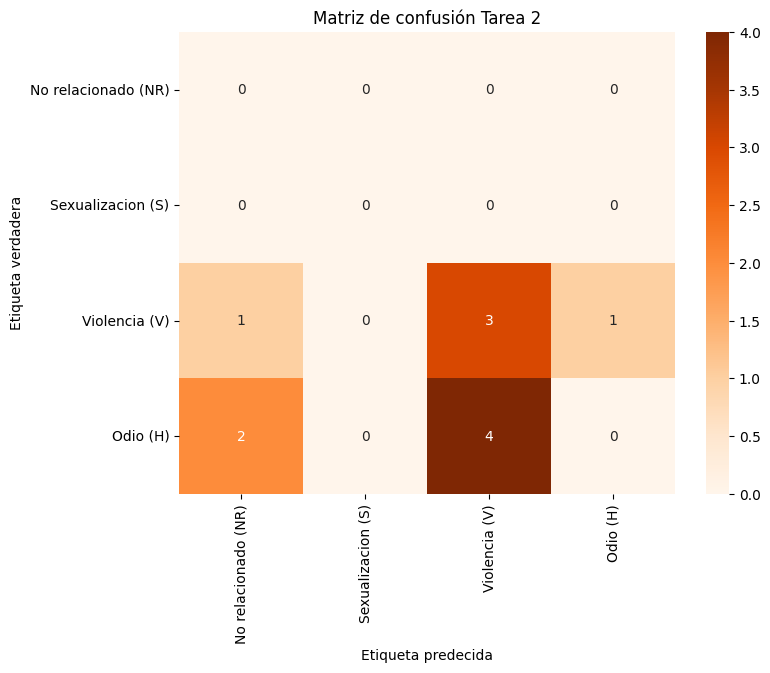

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# --- Calcular y mostrar métricas ---
print(f"\n--- Resultados de la Evaluación (Test Set) ---")
print(f"Total de ejemplos evaluados: {len(true_labels)}")
print(f"Ejemplos donde falló la extracción de la etiqueta: {failed_extractions_count}")

class_labels = ['NR', 'S', 'V', 'H']
class_labels_display = ["No relacionado (NR)", "Sexualizacion (S)", "Violencia (V)", "Odio (H)"]

if not true_labels or not predicted_labels:
    print("\nNo se pudieron calcular las métricas (no hay predicciones válidas).")
else:
    # Calcular métricas usando sklearn
    accuracy = accuracy_score(true_labels, predicted_labels)
    f1_macro = f1_score(true_labels, predicted_labels, average='macro', zero_division=0)
    f1_weighted = f1_score(true_labels, predicted_labels, average='weighted', zero_division=0)
    report = classification_report(true_labels, predicted_labels, labels=class_labels, target_names=class_labels_display, zero_division=0)
    conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=class_labels)

    print(f"\nAccuracy: {accuracy:.4f}")
    print(f"F1 Score (Macro): {f1_macro:.4f}")
    print(f"F1 Score (Weighted): {f1_weighted:.4f}")
    print("\nReporte de Clasificación Detallado:")
    print(report)

    # Grafico de la matriz de confusión
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Oranges', xticklabels=class_labels_display, yticklabels=class_labels_display)
    plt.ylabel('Etiqueta verdadera')
    plt.xlabel('Etiqueta predecida')
    plt.title('Matriz de confusión Tarea 2')
    matriz_path = f"{path}/matrices/prueba.png"
    plt.savefig(matriz_path)
    plt.show()